### Imports iniciais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold


### Pré-Processamento


In [2]:
df = pd.read_csv("akc-data-latest.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

In [4]:

df.rename(columns={"Unnamed: 0": "breeds"}, inplace=True)


In [5]:
#dropando colunas não numéricas, exceto a coluna popularidade e a group, que eu vou usar na classificação

object_cols = df.select_dtypes(include=['object']).columns
object_cols = object_cols.drop(["popularity","group"])

df = df.drop(columns=object_cols)



In [6]:
df.isna().sum()


popularity                  79
min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
group                        0
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
demeanor_value              25
dtype: int64

In [7]:
df.columns

Index(['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight',
       'min_expectancy', 'max_expectancy', 'group', 'grooming_frequency_value',
       'shedding_value', 'energy_level_value', 'trainability_value',
       'demeanor_value'],
      dtype='object')

### Agregação de colunas

In [8]:
df['average_height'] = df[['min_height', 'max_height']].mean(axis=1)
df['average_weight'] = df[['min_weight', 'max_weight']].mean(axis=1)
df['average_expectancy'] = df[['min_expectancy', 'max_expectancy']].mean(axis=1)

# Drop the original min/max columns
df.drop(columns=['min_height', 'max_height', 'min_weight', 'max_weight', 
                 'min_expectancy', 'max_expectancy'], inplace=True)


In [9]:
#Transformando elementos da coluna popularidade em numéricos
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')


In [10]:
(
    df['popularity'] - df['popularity'].min()
)/(
    df['popularity'].max() - df['popularity'].min()
)

0      0.769634
1      0.586387
2      0.308901
3      0.240838
4      0.298429
         ...   
272    0.869110
273         NaN
274    0.727749
275         NaN
276    0.047120
Name: popularity, Length: 277, dtype: float64

In [11]:
1 - (
    df['popularity'] - df['popularity'].min()
)/(
    df['popularity'].max() - df['popularity'].min()
)

0      0.230366
1      0.413613
2      0.691099
3      0.759162
4      0.701571
         ...   
272    0.130890
273         NaN
274    0.272251
275         NaN
276    0.952880
Name: popularity, Length: 277, dtype: float64

In [12]:
df['popularity'] = 1 - (
    df['popularity'] - df['popularity'].min()
)/(
    df['popularity'].max() - df['popularity'].min()
)

In [13]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.name != 'group' else x, axis=0)


### Normalizando os dados

In [14]:
df.set_index('group', inplace=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_esc = scaler.fit_transform(df)


In [16]:
df_esc = pd.DataFrame(df_esc, columns=df.columns, index=df.index)


In [17]:
df_esc

,popularity,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,average_height,average_weight,average_expectancy
group,,,,,,,,,
Toy Group,0.230366,0.50,0.50,0.50,0.75,1.00,0.15,0.047222,0.794118
Hound Group,0.413613,0.75,0.00,0.75,0.00,0.00,0.78,0.305556,0.794118
Terrier Group,0.691099,0.50,0.25,0.50,1.00,0.75,0.66,0.333333,0.735294
Working Group,0.759162,0.75,0.50,0.75,1.00,0.50,0.78,0.555556,0.676471
Working Group,0.701571,0.50,0.50,0.75,0.25,0.75,0.70,0.444444,0.705882
...,...,...,...,...,...,...,...,...,...
Sporting Group,0.130890,0.00,0.50,0.75,0.50,0.50,0.67,0.305556,0.764706
Foundation Stock Service,0.503745,0.00,0.50,0.75,0.25,0.50,0.62,0.244444,0.794118
Non-Sporting Group,0.272251,0.00,0.00,0.75,0.50,0.50,0.40,0.180556,0.911765


In [18]:
df = df_esc

In [19]:
df.reset_index(inplace=True)

### Correlação

<Axes: >

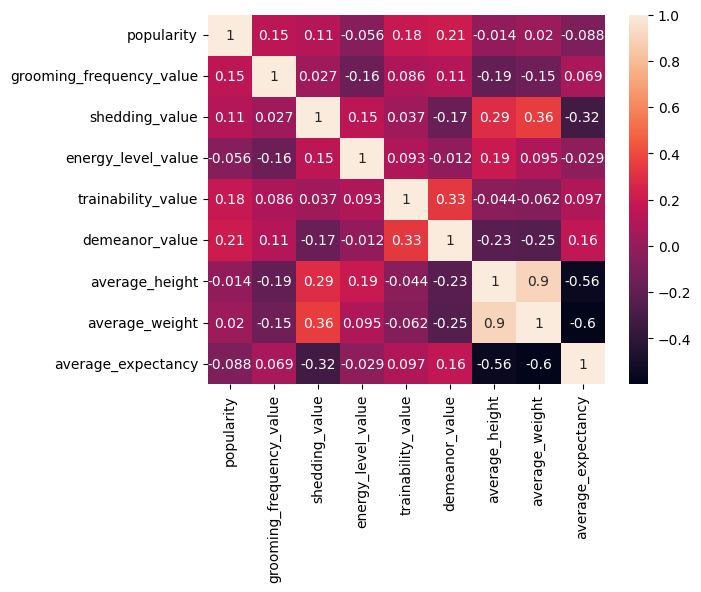

In [20]:
correlacao = df.drop("group", axis=1).corr(method='spearman')
sns.heatmap(correlacao, annot=True)

In [21]:
#como a coluna de avarage_height e average_weight são muito correlacionadas, vou dropar uma delas
df.drop(columns=['average_weight'], inplace=True)

# Supervisionado

### Divisão entre treino e teste

In [22]:
df["group"].isna().sum()

0

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("group", axis=1), df["group"], test_size=0.25, random_state=42)


In [24]:
#Fazendo um oversampling para balancear as classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [25]:
X_resampled

,popularity,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,average_height,average_expectancy
0,0.958115,0.250000,0.750000,1.000000,1.000000,0.750000,0.660000,0.647059
1,0.397906,0.000000,0.411479,0.500000,0.500000,0.500000,0.460000,0.823529
2,0.743455,0.750000,0.500000,0.750000,0.750000,0.500000,0.540000,0.705882
3,0.010471,0.250000,0.500000,0.750000,1.000000,0.750000,0.700000,0.794118
4,0.503745,0.250000,0.250000,0.750000,0.750000,0.500000,0.480000,0.794118
...,...,...,...,...,...,...,...,...
454,0.835103,0.250000,0.435305,0.564695,0.750000,0.814695,0.781183,0.581657
455,0.734491,0.334369,0.500000,0.584369,0.415631,0.750000,0.768881,0.608818
456,0.822395,0.077928,0.327928,0.500000,0.500000,0.577928,0.880649,0.488924
457,0.767523,0.239966,0.869983,0.619983,0.619983,0.380017,0.734398,0.438816


In [26]:
y_resampled.value_counts() 

group
Sporting Group              51
Terrier Group               51
Working Group               51
Foundation Stock Service    51
Herding Group               51
Miscellaneous Class         51
Hound Group                 51
Non-Sporting Group          51
Toy Group                   51
Name: count, dtype: int64

In [27]:
df['group'].value_counts()

group
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: count, dtype: int64

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

model = GaussianNB()

model.fit(X_resampled, y_resampled)
predicted = model.predict(X_test)


### Avaliação de resultados

In [29]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average="micro")

0.5142857142857142

In [30]:
value = df['group'].unique()

<Figure size 1000x700 with 0 Axes>

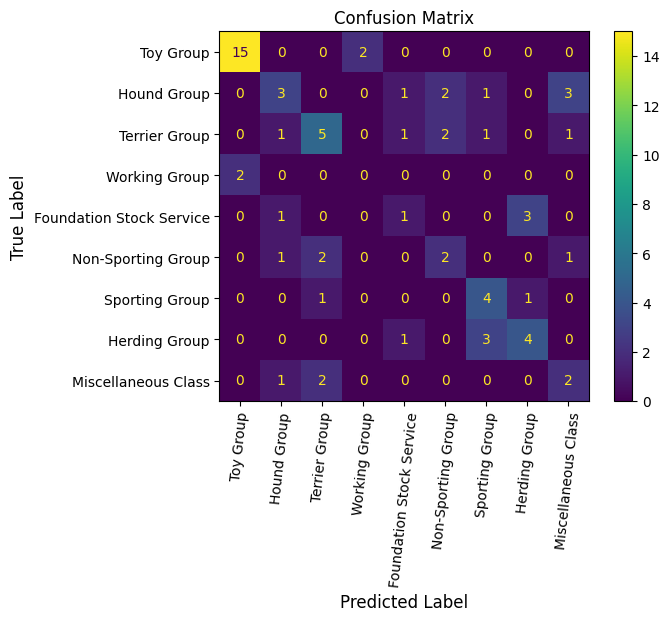

In [31]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


rf = RandomForestClassifier()
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cb5257229b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cb5246c5b70>})

In [33]:

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

max_depth = rand_search.best_params_['max_depth']
n_estimators = rand_search.best_params_['n_estimators']

Best hyperparameters: {'max_depth': 12, 'n_estimators': 291}


In [34]:

rf = RandomForestClassifier(max_depth= max_depth, n_estimators= n_estimators)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=12, n_estimators=291)

### Avaliação de resultados

In [35]:
from sklearn.metrics import f1_score
y_pred = best_rf.predict(X_test)

resultad_rf = f1_score(y_test, y_pred, average="weighted")


print("F1 Score:", resultad_rf)

F1 Score: 0.4656390977443609


<Figure size 1000x700 with 0 Axes>

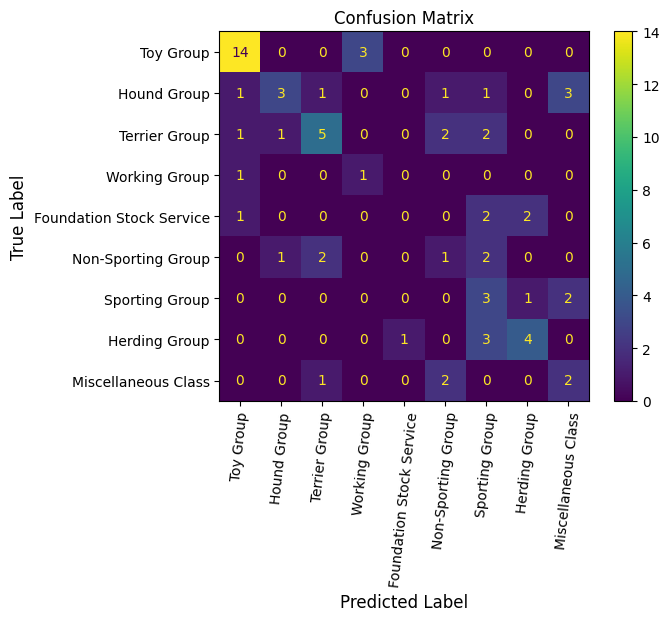

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

/tmp/ipykernel_29388/392278942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')


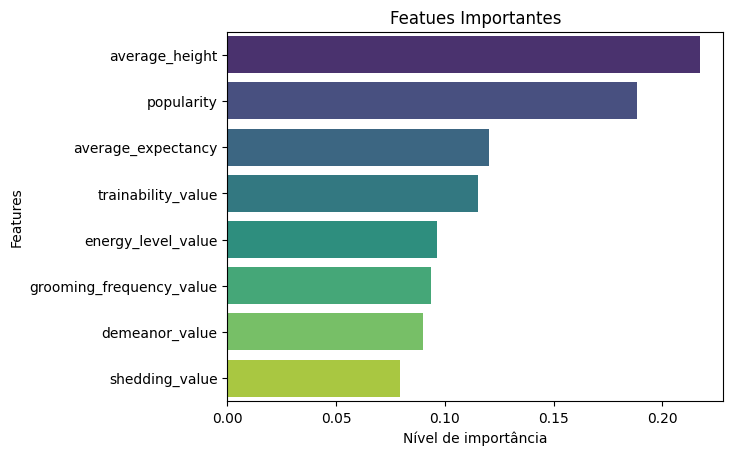

In [37]:
#Uma das principais vantagens de uso de Random Forest é a possibilidade de verificar a importância das features

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')

plt.xlabel('Nível de importância')
plt.ylabel('Features')
plt.title("Featues Importantes")

plt.show()

## MLP

In [38]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_resampled, y_resampled)

/home/felipe/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.4


In [40]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average="weighted")

0.4137755102040816

<Figure size 1000x700 with 0 Axes>

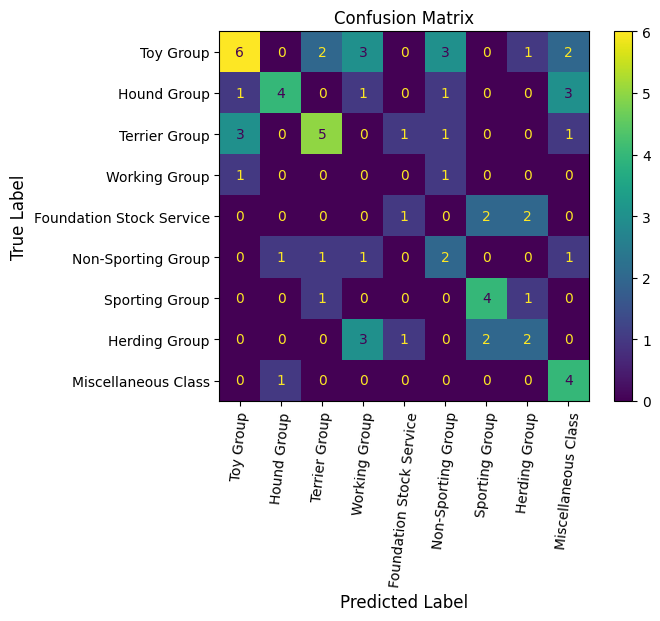

In [41]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

### Freestyle


In [42]:
#Como o Hound group está sendo muito confundido, vou tentar balancear o dataset
df['group'].value_counts()



group
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: count, dtype: int64

# Não Supervisionado

## K-means

In [43]:
from sklearn.cluster import KMeans


In [44]:
df_X = df.drop(columns=["group"])

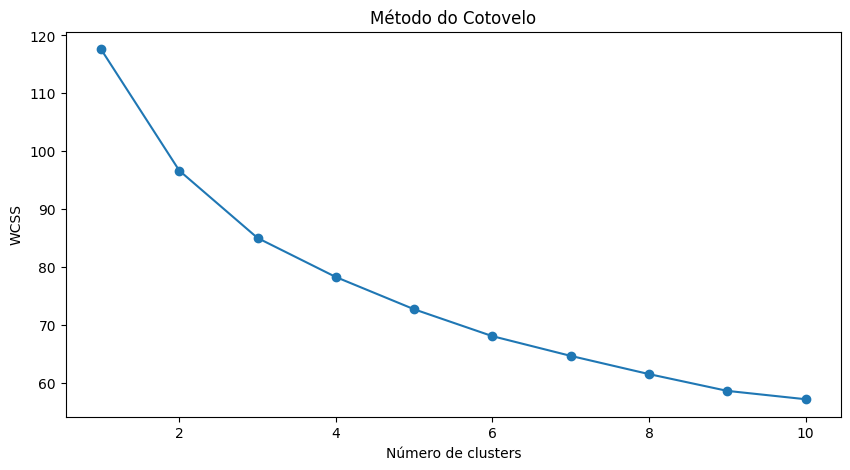

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Aplicar K-means com diferentes números de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_X)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [46]:
print(df_X)

     popularity  grooming_frequency_value  shedding_value  energy_level_value  \
0      0.230366                      0.50            0.50                0.50   
1      0.413613                      0.75            0.00                0.75   
2      0.691099                      0.50            0.25                0.50   
3      0.759162                      0.75            0.50                0.75   
4      0.701571                      0.50            0.50                0.75   
..          ...                       ...             ...                 ...   
272    0.130890                      0.00            0.50                0.75   
273    0.503745                      0.00            0.50                0.75   
274    0.272251                      0.00            0.00                0.75   
275    0.503745                      0.25            0.50                0.75   
276    0.952880                      1.00            0.00                0.50   

     trainability_value  de

In [47]:
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(df_X)

KMeans(n_clusters=3, random_state=0)

In [48]:
# kmeans.predict(X_test)

# X_test["group"] = kmeans.predict(X_test)

# X_test

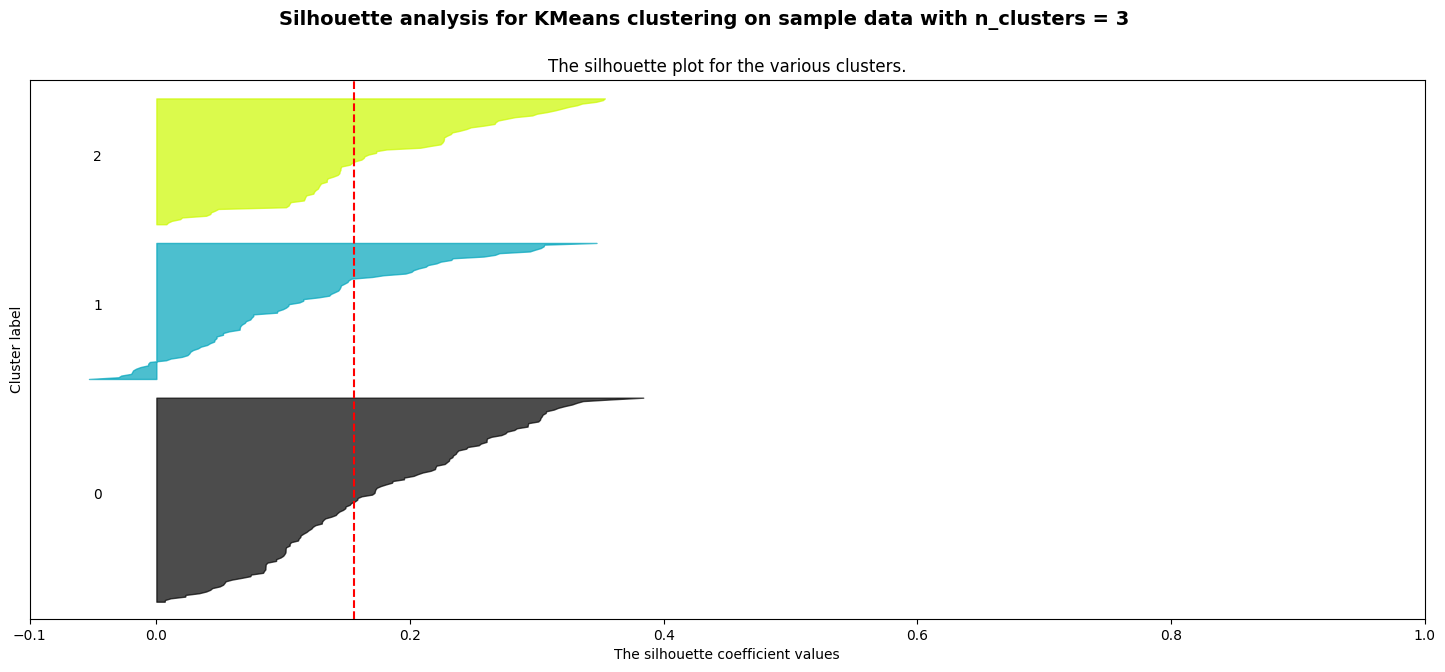

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

# Example with hypothetical data
X = df_X

# Clustering with KMeans
n_clusters = 3  # Example number of clusters
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# Calculate the silhouette scores
silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()

### Métrica de avaliação do modelo (silhueta)

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.fit_predict(X))

0.1554330415425228

## Hierarquia

In [51]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5)

clustered = model.fit_predict(df_X)

In [52]:
# model.fit_predict(df_X)

In [53]:
# from sklearn.metrics import silhouette_score

# silhouette_score(X, model.fit_predict(X))

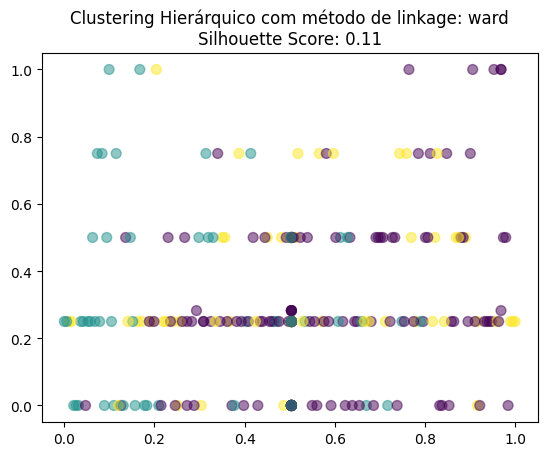

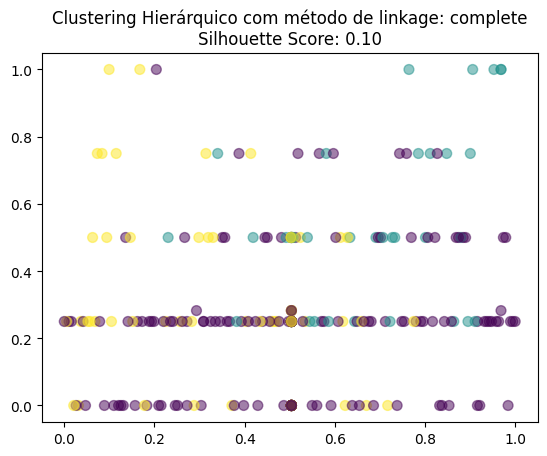

The Silhouette Score for ward linkage: 0.11046839610150704
The Silhouette Score for complete linkage: 0.09660381575685208


In [54]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it's already loaded and cleaned

k = 3
linkage_methods = ['ward', 'complete']

# To store silhouette scores for each linkage method
silhouette_scores = {}

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clustering.fit(X)
    
    # Calculate Silhouette Score
    score = silhouette_score(X, clustering.labels_)
    silhouette_scores[linkage_method] = score
    
    # Plot
    plt.figure()
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.5)
    plt.title(f'Clustering Hierárquico com método de linkage: {linkage_method}\nSilhouette Score: {score:.2f}')
    plt.show()

# Print Silhouette Scores
for method, score in silhouette_scores.items():
    print(f"The Silhouette Score for {method} linkage: {score}")
